In [1]:
#Import basic stuff
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model

#import the custom analysis software
import scipy as sp
import plot_informationfootprint
import seaborn as sns
#style file for plots
import utils_functions
utils_functions.pboc_style_mpl()
import bokeh

We will first load in a data set in a format accepted by the analysis software. The dataset must have the columns 'ct' 'ct_0','ct_1', and 'seq' where 'ct' is the total number of reads, 'ct_0' is the number of reads from the DNA library, and 'ct_1' is the number of reads from the RNAseq readout. 

In [2]:
genelabel = 'aphA'
df = pd.io.parsers.read_csv('aphAAnaerodataset_alldone_with_large',delim_whitespace=True)
print(df)

        ct  ct_0  ct_1                                                seq
0     10.0   5.0   5.0  AAACAAAAAAACACATGAACGTATCTACTTGGTTCAATATAAGGAT...
1      2.0   2.0   0.0  AAACAAAAAAACACATGAACGTATCTACTTGGTTCAATATAAGGAT...
2     10.0   1.0   9.0  AAACAAAAAAAGACAGGAACGTAATGACTGGGTGAAATATAATCAT...
3      9.0   9.0   0.0  AAACAAAAAAAGACAGGAACGTAATTACTGGGTTAAATATTATCAT...
4      1.0   1.0   0.0  AAACAAAAAAAGACAGGAACGTAATTACTGGGTTAAATATTATCAT...
...    ...   ...   ...                                                ...
5067   7.0   3.0   4.0  TTGCAAAAAACGACATGAACGTATTTCCTGGGTTTAATATAATCAG...
5068   3.0   3.0   0.0  TTGCAAAAAACGACATGAACGTATTTCCTGGGTTTAATATAATCAG...
5069  36.0   2.0  34.0  TTGCAAAAAACGACATGAACGTATTTCCTGGGTTTAATATAATCAG...
5070   3.0   0.0   3.0  TTGCAAAAAACGACATGAACGTATTTCCTGGGTTTAATATAATCAG...
5071  14.0   0.0  14.0  TTGCAAAAAACGACATGAACGTATTTCCTGGGTTTAATATAATCAG...

[5072 rows x 4 columns]


we will define necessary functions here and also determine the Wild type sequence 

In [3]:
genedf = pd.io.parsers.read_csv('wtsequences.csv')

wt = str(genedf.loc[genedf['name'] == genelabel,'geneseq'].tolist()[0])
wtlist = np.array(list(wt))

def Compute_Least_Squares(raveledmat,batch,alpha=0):
    '''Ridge regression is the only sklearn regressor that supports sample
        weights, which will make this much faster'''
    clf = linear_model.Lasso(alpha=alpha)
    #clf.fit(raveledmat,batch,sample_weight=sw)
    clf.fit(raveledmat,batch)
    emat = clf.coef_
    return emat

Our goal is to determine the effect of mutation at each position. To do this we first need to parameterize each sequence by whether or not each base pair is mutated. This produces an array of shape number sequences by length of sequence. 

In [4]:
taglength = 20 
seqlength = len(df['seq'][0]) - taglength
seq_dict,inv_dict = utils_functions.choose_dict('dna')

'''we initialize our array where we parameterize the sequence. There is one entry per base pair which
is equal to 1 for mutated, or 0 for wild type. We also include an additional 4 parameters (one for each of A,C,G,T)
per basepair in the mRNA tag'''
all_mutarr = np.zeros((len(df.index),seqlength))

#We will now parameterize our sequences
for i,row in df.iterrows():
    s = np.array(list(row['seq']))
    #clip off tag sequence
    s_clipped = s[:seqlength]
    #determine which bases are mutated
    all_mutarr[i,:seqlength] = (wtlist != s_clipped)
    #add in parameters for the tag
    #tag_mat = seq2mat(s[seqlength:],seq_dict)
    #all_mutarr[i,seqlength:] = tag_mat.ravel(order='F')

#We will use the ratio of mRNA counts to DNA counts to regress against. We add a pseudocount of 1.
thetarget = np.array((df['ct_0']+1)/(df['ct_1']+1))
#We will center the mean to be 0
thetarget = thetarget - np.mean(thetarget)

We then need to fit the effect of mutation from the data. For illustration purposes we now show how this can be done using linear regression. We use a LASSO method, as we expect the number of base pairs that contribute significantly to be relatively low.

In [5]:


#We use Lasso regression with coefficient .03
emat = Compute_Least_Squares(all_mutarr,thetarget,alpha=.03)

We can now plot the results. We will see the effect of mutation on expression.

findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans.


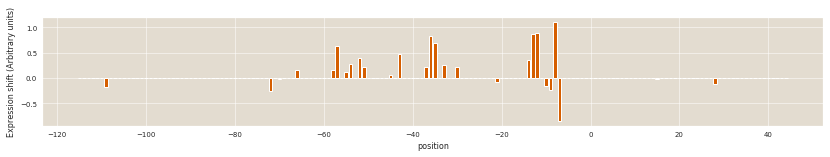

In [6]:
fig,ax = plt.subplots(figsize=(14,2))
ax.set_ylabel('Expression shift (Arbitrary units)')
ax.set_xlabel('position')
plt.bar(range(-115,-115+seqlength),emat,color='r')
plt.show()

We will now convert the expression shift into an information footprint.

In [7]:
smoothinfo, shiftcolors = plot_informationfootprint.main(emat)

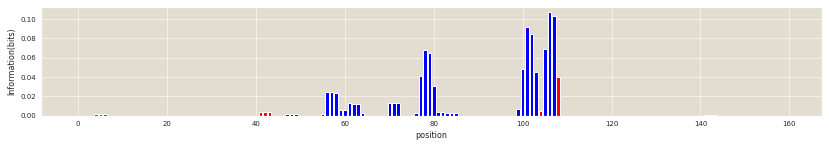

In [9]:
fig,ax = plt.subplots(figsize=(14,2))
ax.set_ylabel('Information(bits)')
ax.set_xlabel('position')
ax.bar(range(160),np.abs(smoothinfo),color=shiftcolors)
plt.show()

Determining the effect of mutation with a LASSO based method works well, and it has the advantage of having little computational cost. However, the LASSO results can be dependent on the regularization parameter (alpha), and we can do a better job using MCMC inference, and so the MCMC method was used to generate all information footprints displayed in the paper. The MCMC inference can be run from the command line, and we ran all our inference on the amazon cloud. The command is

mpathic learn_model -i data_file_name -o model_file_out_name -db database_file_out_name --iterations 300000 --thin 30 --initialize rand

Where:

-i designates the input datafile name 

-o designates the output file name

-db is the file name for saving all MCMC samples during the run

--iterations is the number of MCMC iterations to run

--initialize is how to initialize the inference, doing it randomly allows you to check that nomatter where you start
    you will converge to the same answer

It is important to check that if you run multiple MCMC chains, you will converge to the same answer, even though you start in different places.

We can examine the output of one of those MCMC runs here.

In [10]:
#load in MCMC trace
ematMCMC = np.load('aphA_database.npy')

We can examine the distribution of a sampled parameter

In [1]:
histogramplot = plt.hist(ematMCMC[:,120])
plt.show()

NameError: name 'plt' is not defined